# Pipeline Configuration Benchmarking 

In [30]:
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.dataset import SegmentationDataset
from src.data_utils import plot_sample_batch
from src.data_pipeline import SegmentationDataPipeline


%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Dataset

In [2]:
IMG_SHAPE = (256, 1600)
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"

# instantiate dataset
sd = SegmentationDataset(
    label_file=ANNOTATIONS_PATH, img_dir_path=TRAIN_IMG_PATH, img_shape=IMG_SHAPE
)

### Pipeline with inline preprocessing

In [7]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.2)
X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="inline")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="inline")

In [10]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="inline",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_inline = sdp(X_train, y_train)

Batching


In [11]:
sample_inline = list(train_dataset_inline.take(1).as_numpy_iterator())

In [ ]:
tf.keras.utils.save_img(

In [ ]:
sample_inline[0][0].shape, sample_inline[0][1].shape

2022-10-08 15:35:08.548656: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'split'
Traceback (most recent call last):

  File "/home/cdsw/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/cdsw/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/cdsw/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/cdsw/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/cdsw/src/data_pipeline.py", line 110, in prepare_mask_label
    class_mask = rle2mask(

  File "/home/cdsw/src/data_utils.py", line 22, in rle2mask
    nums = [int(x) for x in

In [6]:
sample_inline[0][0].shape, sample_inline[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 4))

### Pipeline with preemptive preprocessing

In [39]:
# create train/test & x/y splits
train_imgs, test_imgs = sd.get_train_test_split(test_size=0.2)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

In [40]:
# instantiate dataset
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": 8,
        "prefetch": False,  # off if False
    },
)

# create dataset pipelines
train_dataset_pp = sdp(X_train, y_train)
test_dataset_pp = sdp(X_test, y_test)

Batching
Batching


In [41]:
sample_pp = list(train_dataset_pp.take(1).as_numpy_iterator())

In [42]:
sample_pp[0][0].shape, sample_pp[0][1].shape

((8, 256, 1600, 3), (8, 256, 1600, 4))

In [43]:
sample_pp[0][0][0].shape

(256, 1600, 3)

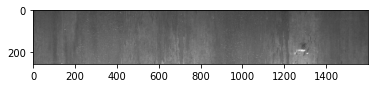

In [44]:
plt.imshow(sample_pp[0][0][0])

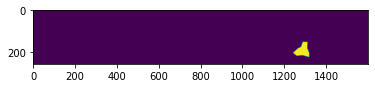

In [45]:
plt.imshow(np.expand_dims(sample_pp[0][1][0][..., 2], axis=-1))

(array([3.12600e+03, 2.76240e+05, 5.95536e+05, 2.88987e+05, 5.40120e+04,
        8.55600e+03, 1.10100e+03, 4.77000e+02, 3.27000e+02, 4.38000e+02]),
 array([0.16470589, 0.2482353 , 0.3317647 , 0.4152941 , 0.49882352,
        0.58235294, 0.66588235, 0.74941176, 0.8329412 , 0.9164706 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

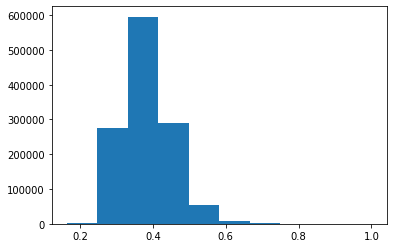

In [46]:
plt.hist(sample_pp[0][0][0].flatten())

(array([1635219.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,    3181.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

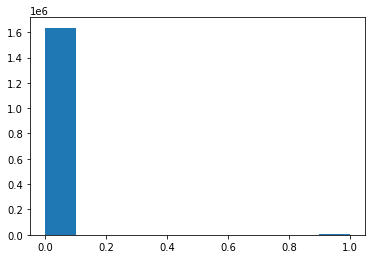

In [47]:
plt.hist(sample_pp[0][1][0].flatten())

### Plot a batch


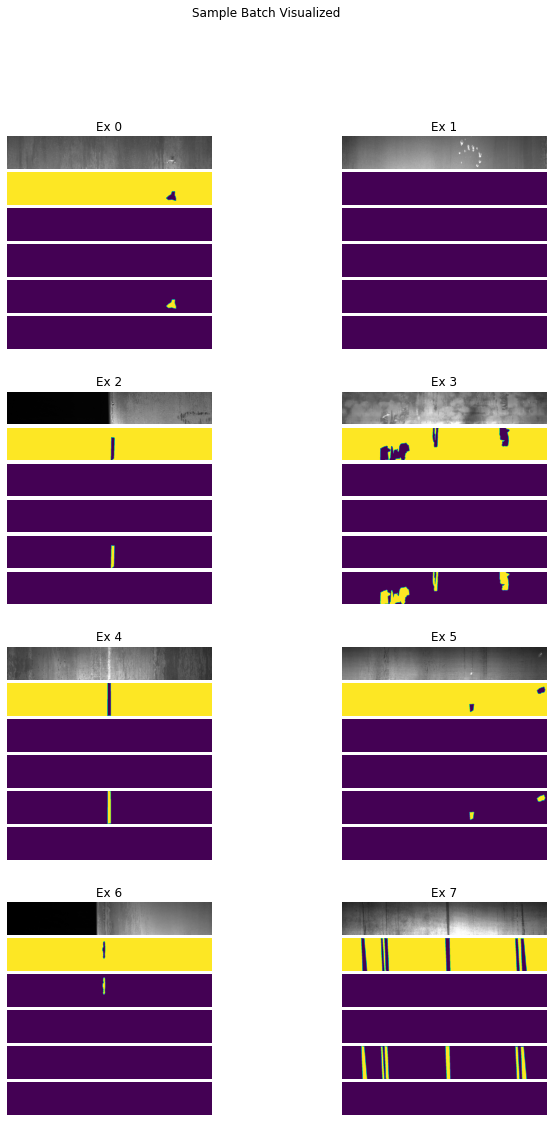

In [23]:
plot_sample_batch(sample_pp)

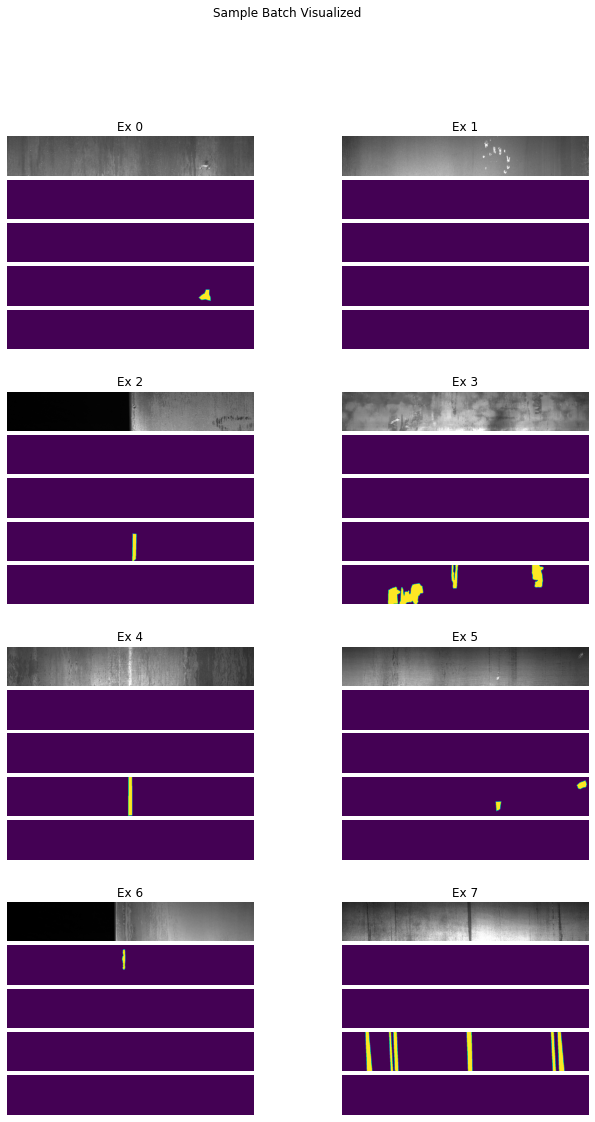

In [12]:
plot_sample_batch(sample_inline)

## Benchmarking (TO DO)

## `tf.data` pipeline

Benchmark the following scenarios:

0. Impact of cache, batch, prefetch?
1. Masks are RLE encoded in csv file (i.e. tf.data pipeline has to transform into Tensors)
2. Masks and images are pre-saved as Tensors (i.e. all image masks are converted to tf.records prior)
3. Masks/images are loaded using `keras.utils.Sequence` (ex. https://keras.io/examples/vision/oxford_pets_image_segmentation/)
4. ImageDataGenerator in keras...
5. Using np_func / py_func for RLE decoding vs. raw TensorFlow functions

In [16]:
def benchmark_dataloading(dataset, n_epochs):
    start = time.time()
    for epoch in range(n_epochs):
        for i, sample in enumerate(dataset):
            time.sleep(0.01)  # imitate train step
            pass
    end = time.time()
    print("Execution time:", end - start)

In [17]:
# batch only
benchmark_dataloading(train_dataset, 1)

Execution time: 310.7924337387085


In [8]:
# batch only
benchmark_dataloading(train_dataset, 5)

Execution time: 11.809537172317505


In [13]:
# cache and batch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.296800374984741


In [16]:
# batch, cache, prefetch
benchmark_dataloading(train_dataset, 5)

Execution time: 3.540153741836548
